<a href="https://colab.research.google.com/github/lisaong/mldds-courseware/blob/master/02_BasicMLAlgorithms/examples/Parkinsons_Classification_with_GridSearch_and_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification Example

This is an example of training a classification model to predict Parkinson's Disease.

It also illustrates how to handle a dataset where features >> rows. In this case, I chose to apply both SelectKBest and PCA.

### Goal
The goal is to predict the disease based on features pre-extracted from speech recordings of Parkinson's disease patients.

### Dataset
https://archive.ics.uci.edu/ml/datasets/Parkinson%27s+Disease+Classification

Various speech signal processing algorithms including Time Frequency Features, Mel Frequency Cepstral Coefficients (MFCCs), Wavelet Transform based Features, Vocal Fold Features and TWQT features have been applied to the speech recordings of Parkinson's Disease (PD) patients to extract clinically useful information for PD assessment.

The data used in this study were gathered from 188 patients with PD (107 men and 81 women) with ages ranging from 33 to 87 (65.1±10.9) at the Department of Neurology in Cerrahpaya Faculty of Medicine, Istanbul University. The control group consists of 64 healthy individuals (23 men and 41 women) with ages varying between 41 and 82 (61.1±8.9). During the data collection process, the microphone is set to 44.1 KHz and following the physician's examination, the sustained phonation of the vowel /a/ was collected from each subject with three repetitions.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='whitegrid')
%matplotlib inline

### Data Engineering

- Load dataset
- Clean missing values, if any
- Explore pairplot, correlation

In [2]:
# header = 1 because header is in the first line
# index_col = 0 because index column is in the first column
df = pd.read_csv('https://github.com/lisaong/mldds-courseware/raw/master/data/parkinsons/pd_speech_features.csv', header=1, index_col=0)
df.head()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,...,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,0.00067,0.00129,0.00200,0.05883,0.517,0.03011,0.03496,0.04828,0.09034,0.970805,0.036223,18.995,69.997496,76.088046,72.465512,539.342735,1031.849040,2447.162183,3655.054806,101.092218,83.147440,255.214830,396.643631,0.77778,11.7245,2.8277,1.17300,0.26512,0.083127,1200445.612,...,0.071728,0.010352,-2.73030,66.5007,36.9934,26.3508,51.9577,21.5451,8.2488,8.0024,6.9635,6.9189,5.0622,4.6068,7.7218,2.7224,2.4171,2.9383,4.2077,3.1541,2.8531,2.7496,2.1550,2.9457,2.1993,1.9830,1.8314,2.0062,1.6058,1.5466,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,0.00052,0.00112,0.00157,0.05516,0.502,0.02320,0.03675,0.06195,0.06961,0.984322,0.017974,21.497,67.415903,73.046374,71.528945,564.363614,1016.367294,2383.565201,3498.681572,58.465428,86.487292,248.357127,218.229722,0.81250,13.8284,2.8908,1.02210,0.22004,0.127410,1298455.445,...,0.729330,0.780410,5.22940,8643.9860,3962.0554,2976.2411,4329.0607,4005.1329,1127.6762,116.5331,20.2332,13.6395,12.5514,13.6965,60.8974,6.2958,3.0323,3.4039,4.3794,2.4329,2.0585,2.1839,2.2061,3.0999,1.9824,1.6227,1.5783,2.0470,1.5772,1.5530,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,0.00057,0.00111,0.00171,0.09902,0.897,0.05094,0.06497,0.07772,0.15282,0.974846,0.026313,17.651,62.661706,71.633549,68.086583,548.444604,1032.406341,2357.826954,3678.128717,160.387771,54.685168,151.694847,84.240339,0.81818,26.9273,2.6975,0.84951,0.15756,0.116890,1272869.841,...,0.269510,-0.005522,0.35054,29.2717,32.4971,38.9453,85.1480,62.5132,9.7308,6.8890,6.1357,5.4926,3.9078,4.0864,6.9828,3.4411,3.5173,3.7204,4.2212,3.4881,3.4851,3.3007,2.0427,3.1436,2.1203,1.6627,1.6731,3.2597,1.5921,1.5399,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,0.00149,0.00268,0.00446,0.05451,0.527,0.02395,0.02857,0.04462,0.07185,0.968343,0.042003,19.865,76.306989,81.000749,79.190593,819.529588,1201.813897,3154.035654,4122.163933,238.667052,191.984916,573.752909,526.147599,0.98548,139.5744,1.6961,0.83405,0.17295,0.147370,1932289.206,...,0.366920,-0.492650,0.19164,591.0116,65.3827,53.9852,45.4458,34.6650,88.3259,46.6869,23.2911,19.2022,42.3957,100.3649,7.1967,6.3892,6.5496,6.0264,4.7656,4.8909,4.2531,3.029

In [3]:
df.columns

Index(['gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses',
       'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter',
       'locAbsJitter',
       ...
       'tqwt_kurtosisValue_dec_28', 'tqwt_kurtosisValue_dec_29',
       'tqwt_kurtosisValue_dec_30', 'tqwt_kurtosisValue_dec_31',
       'tqwt_kurtosisValue_dec_32', 'tqwt_kurtosisValue_dec_33',
       'tqwt_kurtosisValue_dec_34', 'tqwt_kurtosisValue_dec_35',
       'tqwt_kurtosisValue_dec_36', 'class'],
      dtype='object', length=754)

In [4]:
# check for missing values across all rows and columns
df.isna().sum().sum()

0

In [5]:
# too many columns for info to display
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756 entries, 0 to 251
Columns: 754 entries, gender to class
dtypes: float64(749), int64(5)
memory usage: 4.4 MB


In [6]:
df['class'].describe()

count    756.000000
mean       0.746032
std        0.435568
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: class, dtype: float64

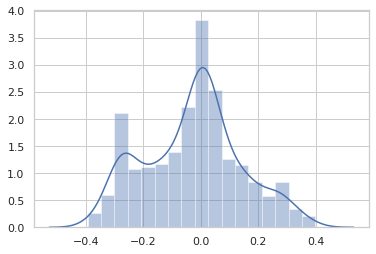

In [7]:
# let's compute correlation against target and plot the correlation values
class_corr = df.corr()['class']

# remove the 1.0 correlation (class with itself)
class_corr = class_corr[class_corr < 1]

sns.distplot(class_corr.values)
plt.show()

In [8]:
# let's get some percentile values
abs(class_corr).describe()

count    753.000000
mean       0.131980
std        0.106960
min        0.000044
25%        0.033748
50%        0.107633
75%        0.225739
max        0.398695
Name: class, dtype: float64

In [9]:
# threshold of top features (mean + 2*std)
threshold = abs(class_corr).mean() + 2*abs(class_corr).std()

mask = abs(class_corr) > threshold
class_corr[mask]

mean_MFCC_2nd_coef             0.398695
std_6th_delta_delta            0.349046
std_7th_delta_delta            0.354239
std_8th_delta_delta            0.364256
std_9th_delta_delta            0.364333
tqwt_entropy_shannon_dec_11   -0.347899
tqwt_entropy_log_dec_12       -0.381003
tqwt_stdValue_dec_11          -0.391081
tqwt_stdValue_dec_12          -0.393029
tqwt_stdValue_dec_13          -0.353249
tqwt_minValue_dec_11           0.366552
tqwt_minValue_dec_12           0.395740
tqwt_minValue_dec_13           0.365264
tqwt_maxValue_dec_11          -0.378485
tqwt_maxValue_dec_12          -0.391288
tqwt_maxValue_dec_13          -0.361800
tqwt_kurtosisValue_dec_27     -0.347604
Name: class, dtype: float64

In [10]:
top_corr_columns = class_corr[mask].index
top_corr_columns

Index(['mean_MFCC_2nd_coef', 'std_6th_delta_delta', 'std_7th_delta_delta',
       'std_8th_delta_delta', 'std_9th_delta_delta',
       'tqwt_entropy_shannon_dec_11', 'tqwt_entropy_log_dec_12',
       'tqwt_stdValue_dec_11', 'tqwt_stdValue_dec_12', 'tqwt_stdValue_dec_13',
       'tqwt_minValue_dec_11', 'tqwt_minValue_dec_12', 'tqwt_minValue_dec_13',
       'tqwt_maxValue_dec_11', 'tqwt_maxValue_dec_12', 'tqwt_maxValue_dec_13',
       'tqwt_kurtosisValue_dec_27'],
      dtype='object')

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


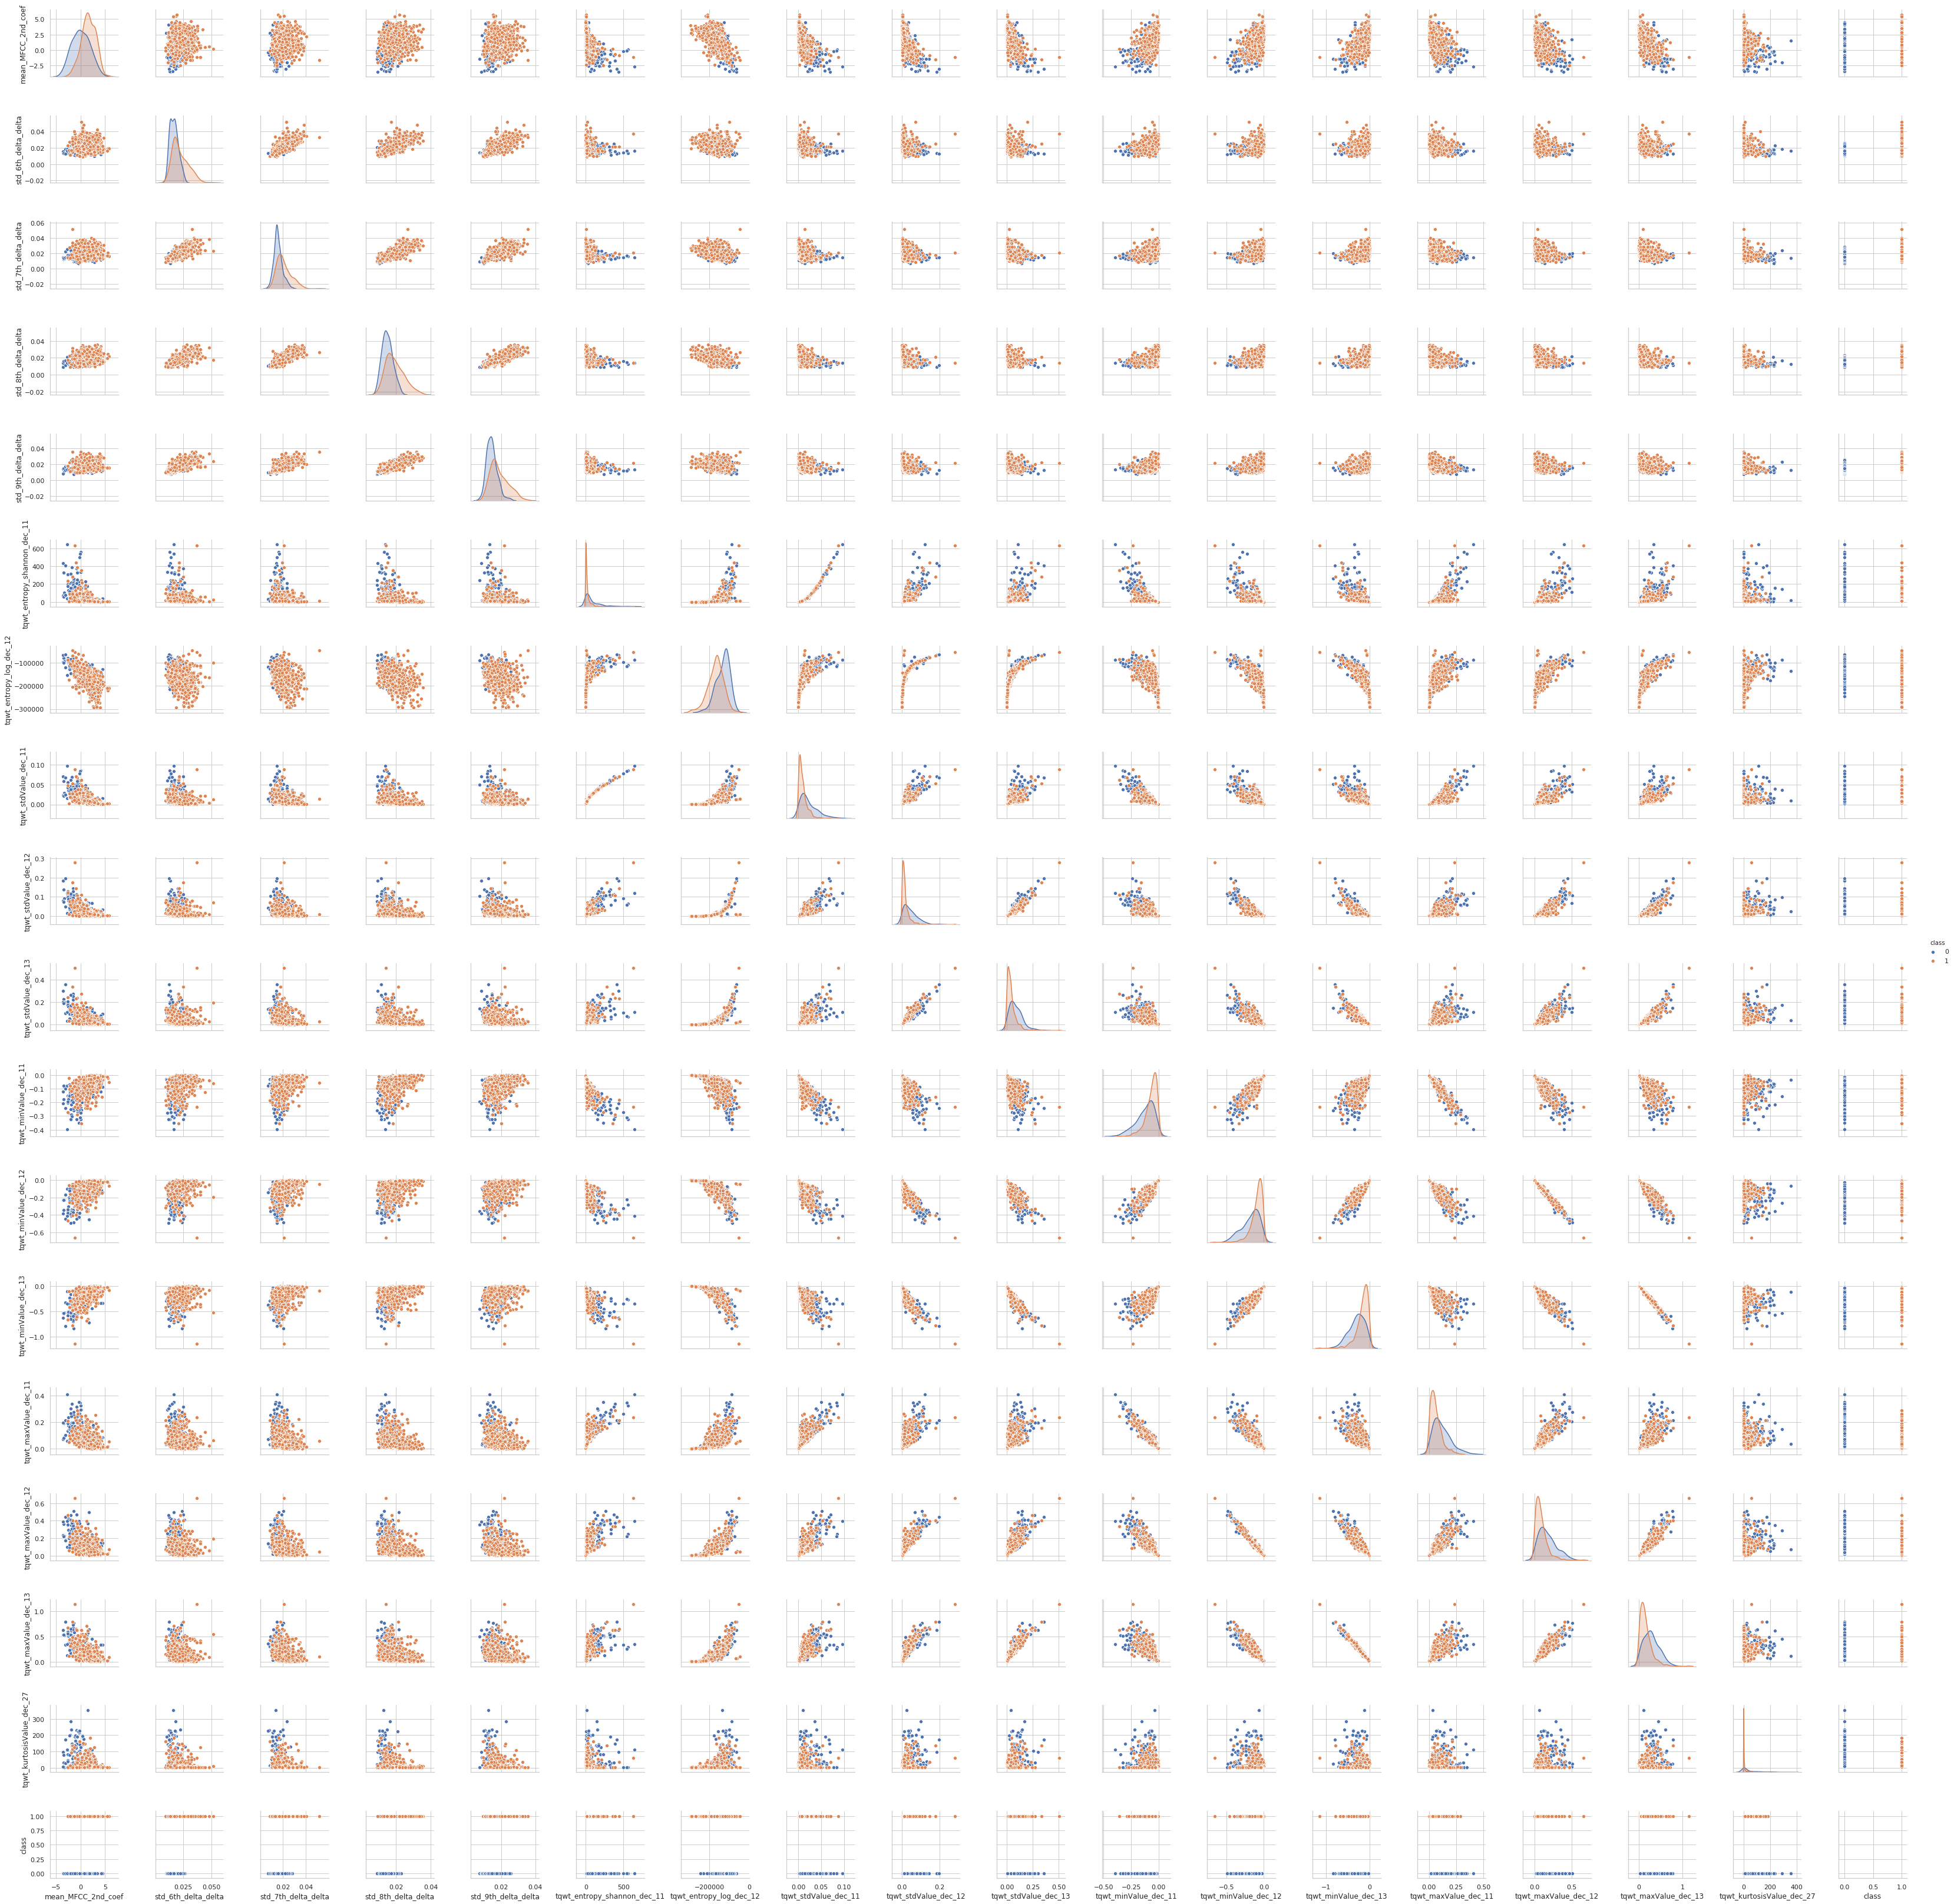

In [11]:
# Show a pairplot colour-coded based on class
sns.pairplot(pd.concat([df.loc[:, top_corr_columns], df['class']], 
                       axis=1),
            hue='class') # colour code based on class label (0 or 1)
plt.show()

In [0]:
# Some potential boundaries from the pairplot above for quite a few features.

# Let's do a PCA plot to get a holistic view along the princpal components.
# We will use a 2d plot and colour code it with the class.
# Let's only look at the top correlated columns so that the PCA is clearer.

X = df.loc[:, top_corr_columns]
y = df['class']

scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

pca = PCA(n_components=2)
Z_2d = pca.fit_transform(X_sc)

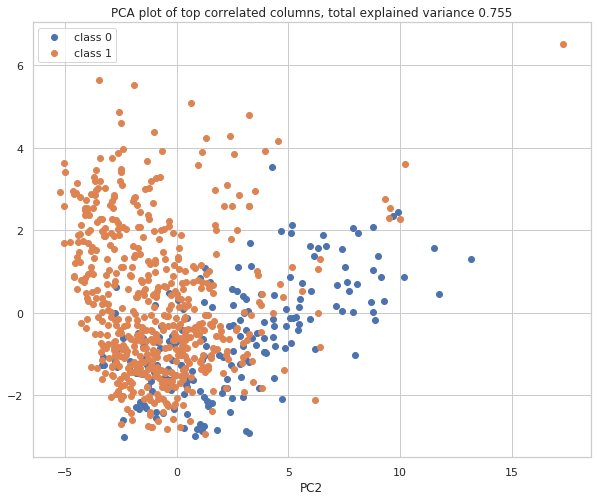

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))

# Overlay scatter plots of PC1 vs PC2, filtered by class value
class0_mask = y == 0
ax.scatter(Z_2d[class0_mask, 0], Z_2d[class0_mask, 1], label='class 0') # class 0 samples
class1_mask = y == 1
ax.scatter(Z_2d[class1_mask, 0], Z_2d[class1_mask, 1], label='class 1') # class 1 samples

total_explained_variance = pca.explained_variance_ratio_.sum()
ax.set_title(f'PCA plot of top correlated columns, total explained variance {total_explained_variance:.3f}')
ax.set_xlabel('PC1')
ax.set_xlabel('PC2')

ax.legend()
plt.show()

In [0]:
# from the PCA plot, we see a few outliers, let's see if we can remove them

PC1 = Z_2d[:, 0]
inlier_mask_PC1 = abs(PC1) < (np.mean(PC1) + 2*np.std(PC1))

PC2 = Z_2d[:, 1]
inlier_mask_PC2 = abs(PC2) < (np.mean(PC2) + 2*np.std(PC2))

In [0]:
# rerun PCA without the outliers
X = df.loc[inlier_mask_PC1 & inlier_mask_PC2, top_corr_columns]
y = df.loc[inlier_mask_PC1 & inlier_mask_PC2, 'class']

scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

pca = PCA(n_components=2)
Z_2d = pca.fit_transform(X_sc)

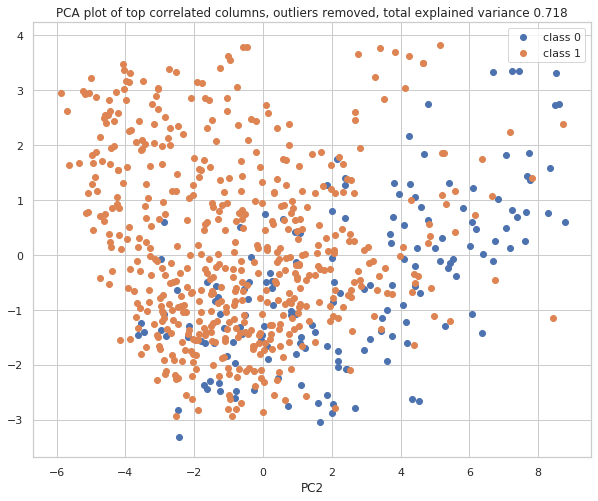

In [16]:
fig, ax = plt.subplots(figsize=(10, 8))

# Overlay scatter plots of PC1 vs PC2, filtered by class value
class0_mask = y == 0
ax.scatter(Z_2d[class0_mask, 0], Z_2d[class0_mask, 1], label='class 0') # class 0 samples
class1_mask = y == 1
ax.scatter(Z_2d[class1_mask, 0], Z_2d[class1_mask, 1], label='class 1') # class 1 samples

total_explained_variance = pca.explained_variance_ratio_.sum()
ax.set_title(f'PCA plot of top correlated columns, outliers removed, total explained variance {total_explained_variance:.3f}')
ax.set_xlabel('PC1')
ax.set_xlabel('PC2')

ax.legend()
plt.show()

### Feature Engineering

- Run and tune SelectKBest
- Consider whether PCA should be run to further reduce the feature space

In [17]:
# Even though we filtered out the columns manually using correlation, 
# let's still run SelectKBest to see if it agrees with the manual analysis

inliers = inlier_mask_PC1 & inlier_mask_PC2

features = df.loc[inliers, df.columns != 'class'] 
target = df.loc[inliers, 'class']

kbest = SelectKBest(k='all', score_func=f_classif) # f_classif should be used for classification
                                                   # f_regression for regression
kbest.fit(features, target)
kbest.scores_

array([1.28800017e+01, 6.40759661e+00, 6.56876403e+01, 4.32636168e+01,
       5.15773207e+01, 5.16372130e+01, 2.89478385e+01, 5.23413313e+00,
       2.97799399e+01, 2.61487444e+01, 2.19265208e+01, 2.65476387e+01,
       2.19216205e+01, 1.61137125e+01, 1.91157227e+01, 1.05287450e+01,
       1.41130565e+01, 3.12678374e+01, 1.05290940e+01, 9.44116635e+00,
       7.66907970e+00, 3.41898361e+01, 4.86726018e+01, 3.46914020e+01,
       4.22426719e+01, 4.37884033e+01, 2.31168903e+01, 8.90364154e-01,
       4.43333607e-01, 4.18713449e+00, 1.91420227e-01, 3.75498035e+00,
       2.42534804e+00, 7.87359042e+00, 1.48005946e+01, 9.69174434e+00,
       1.71247203e+01, 5.93550883e-01, 1.05553110e+01, 2.05587620e+01,
       4.00038898e+00, 9.57020565e+00, 4.52000269e+01, 1.80502196e+00,
       4.91609099e+01, 7.55399563e+00, 2.00225731e+00, 8.19304880e-01,
       2.30329727e+01, 1.77694910e+01, 5.82244288e-02, 2.63186795e+01,
       9.51041389e+00, 1.16618495e+01, 5.06742685e+00, 2.56084657e+01,
      

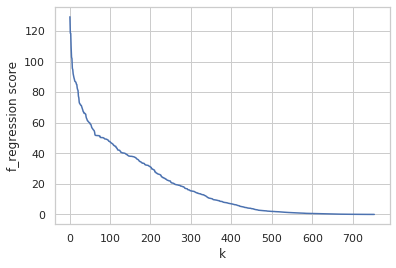

In [18]:
num_cols = len(features.columns)
ks = range(1, num_cols+1)
scores_descending = -np.sort(-kbest.scores_)

plt.plot(ks, scores_descending)
plt.xlabel('k')
plt.ylabel('f_regression score')
plt.show()

### Training

From the curve above, there are a many ks we can try (elbow region is large witn no definite kink (range 50-300)).

This is where a Pipeline + GridSearchCV can be used to tune kBest *while* training the model

- https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
- https://scikit-learn.org/stable/tutorial/statistical_inference/putting_together.html

### Training Flow
- Train Test Split with stratified split

- Setup Pipeline
  - Apply KBest
  - Apply Standard Scaling
  - Apply PCA because k >> number of samples
  - Train SGDClassifier
  
- Use GridSearchCV to tune the following:
  - KBest: k
  - PCA: n_components
  - SGDClassifier: alpha (regularization)

In [0]:
# Train test split should be done in a stratified manner to preserve class balance in the
# train and test sets

X_train, X_test, y_train, y_test = train_test_split(features, target, stratify=target, random_state=25)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((519, 753), (174, 753), (519,), (174,))

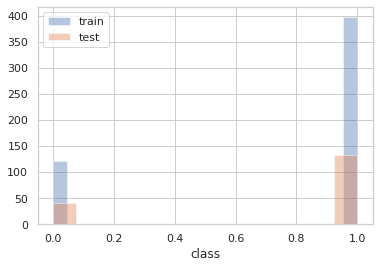

In [22]:
# observe the effect of stratify=target on maintaining class balance across train and test sets
sns.distplot(y_train, label='train', kde=False) # just need to check histogram
sns.distplot(y_test, label='test', kde=False) # just need to check histogram
plt.legend()
plt.show()

In [23]:
# Define a pipeline to search for the best combination of k, PCA, and classifier settings

kbest = SelectKBest(score_func=f_classif)
scaler = StandardScaler()
pca = PCA()
logistic = SGDClassifier(loss='log', penalty='l2', early_stopping=True, random_state=25, tol=1e-5)

pipe = Pipeline(steps=[
    ('kbest', kbest),
    ('scaler', scaler),
    ('pca', pca),
    ('logistic', logistic)
])

# Parameters of pipelines can be set using '__' separated parameter names
param_grid = {
    'kbest__k' : [150, 200, 250, 300],
    'pca__n_components' : [5, 20, 30, 40, 50, 60],
    'logistic__alpha' : np.logspace(-4, 4, 5)  # [1.e-04, 1.e-02, 1.e+00, 1.e+02, 1.e+04]
}

search = GridSearchCV(pipe, param_grid, cv=3, verbose=10)
search.fit(X_train, y_train)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV] kbest__k=150, logistic__alpha=0.0001, pca__n_components=5 .......
[CV]  kbest__k=150, logistic__alpha=0.0001, pca__n_components=5, score=0.718, total=   0.1s
[CV] kbest__k=150, logistic__alpha=0.0001, pca__n_components=5 .......
[CV]  kbest__k=150, logistic__alpha=0.0001, pca__n_components=5, score=0.740, total=   0.0s
[CV] kbest__k=150, logistic__alpha=0.0001, pca__n_components=5 .......
[CV]  kbest__k=150, logistic__alpha=0.0001, pca__n_components=5, score=0.767, total=   0.0s
[CV] kbest__k=150, logistic__alpha=0.0001, pca__n_components=20 ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s


[CV]  kbest__k=150, logistic__alpha=0.0001, pca__n_components=20, score=0.787, total=   0.0s
[CV] kbest__k=150, logistic__alpha=0.0001, pca__n_components=20 ......
[CV]  kbest__k=150, logistic__alpha=0.0001, pca__n_components=20, score=0.740, total=   0.0s
[CV] kbest__k=150, logistic__alpha=0.0001, pca__n_components=20 ......
[CV]  kbest__k=150, logistic__alpha=0.0001, pca__n_components=20, score=0.785, total=   0.0s
[CV] kbest__k=150, logistic__alpha=0.0001, pca__n_components=30 ......
[CV]  kbest__k=150, logistic__alpha=0.0001, pca__n_components=30, score=0.805, total=   0.1s
[CV] kbest__k=150, logistic__alpha=0.0001, pca__n_components=30 ......


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.4s remaining:    0.0s


[CV]  kbest__k=150, logistic__alpha=0.0001, pca__n_components=30, score=0.775, total=   0.1s
[CV] kbest__k=150, logistic__alpha=0.0001, pca__n_components=30 ......
[CV]  kbest__k=150, logistic__alpha=0.0001, pca__n_components=30, score=0.814, total=   0.1s
[CV] kbest__k=150, logistic__alpha=0.0001, pca__n_components=40 ......


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.6s remaining:    0.0s


[CV]  kbest__k=150, logistic__alpha=0.0001, pca__n_components=40, score=0.822, total=   0.1s
[CV] kbest__k=150, logistic__alpha=0.0001, pca__n_components=40 ......
[CV]  kbest__k=150, logistic__alpha=0.0001, pca__n_components=40, score=0.832, total=   0.1s
[CV] kbest__k=150, logistic__alpha=0.0001, pca__n_components=40 ......
[CV]  kbest__k=150, logistic__alpha=0.0001, pca__n_components=40, score=0.773, total=   0.1s
[CV] kbest__k=150, logistic__alpha=0.0001, pca__n_components=50 ......
[CV]  kbest__k=150, logistic__alpha=0.0001, pca__n_components=50, score=0.810, total=   0.1s
[CV] kbest__k=150, logistic__alpha=0.0001, pca__n_components=50 ......
[CV]  kbest__k=150, logistic__alpha=0.0001, pca__n_components=50, score=0.821, total=   0.1s
[CV] kbest__k=150, logistic__alpha=0.0001, pca__n_components=50 ......
[CV]  kbest__k=150, logistic__alpha=0.0001, pca__n_components=50, score=0.779, total=   0.1s
[CV] kbest__k=150, logistic__alpha=0.0001, pca__n_components=60 ......
[CV]  kbest__k=1

[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   34.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('kbest',
                                        SelectKBest(k=10,
                                                    score_func=<function f_classif at 0x7f11d2b07268>)),
                                       ('scaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None,
                                            random_state=None,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       (...
     

In [24]:
search.best_score_ # the score is ACCURACY for classification

0.8420038535645472

In [25]:
search.best_params_

{'kbest__k': 300, 'logistic__alpha': 0.01, 'pca__n_components': 40}

In [26]:
# examine the search results
search_results = pd.DataFrame(search.cv_results_)
search_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kbest__k,param_logistic__alpha,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.045689,0.004732,0.004210,0.000128,150,0.0001,5,"{'kbest__k': 150, 'logistic__alpha': 0.0001, '...",0.718391,0.739884,0.767442,0.741811,0.020071,71
1,0.044566,0.000550,0.004778,0.000559,150,0.0001,20,"{'kbest__k': 150, 'logistic__alpha': 0.0001, '...",0.787356,0.739884,0.784884,0.770713,0.021822,66
2,0.066828,0.017736,0.007207,0.002140,150,0.0001,30,"{'kbest__k': 150, 'logistic__alpha': 0.0001, '...",0.804598,0.774566,0.813953,0.797688,0.016789,47
3,0.092743,0.003913,0.011825,0.004355,150,0.0001,40,"{'kbest__k': 150, 'logistic__alpha': 0.0001, '...",0.821839,0.832370,0.773256,0.809249,0.025704,36
4,0.092964,0.001882,0.009484,0.000893,150,0.0001,50,"{'kbest__k': 150, 'logistic__alpha': 0.0001, '...",0.810345,0.820809,0.779070,0.803468,0.017702,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.077853,0.003036,0.004463,0.000059,300,10000,20,"{'kbest__k': 300, 'logistic__alpha': 10000.0, ...",0.235632,0.763006,0.767442,0.587669,0.250014,97
116,0.100397,0.023092,0.006152,0.002018,300,10000,30,"{'kbest__k': 300, 'logistic__alpha': 10000.0, ...",0.235632,0.763006,0.767442,0.587669,0.250014,97
117,0.099380,0.026397,0.006374,0.001976,300,10000,40,"{'kbest__k': 300, 'logistic__alpha': 10000.0, ...",0.235632,0.763006,0.767442,0.587669,0.250014,97
118,0.110302,0.002058,0.006182,0.001965,300,10000,50,"{'kbest__k': 300, 'logistic__alpha': 10000.0, ...",0.235632,0.763006,0.767442,0.587669,0.250014,97


In [27]:
# mean and std VALIDATION set accuracies for each parameter
search_results.groupby(by=['param_kbest__k'])['mean_test_score', 'std_test_score'].mean()

,mean_test_score,std_test_score
param_kbest__k,,
150,0.719846,0.113299
200,0.727168,0.110753
250,0.732370,0.101856
300,0.735067,0.103057


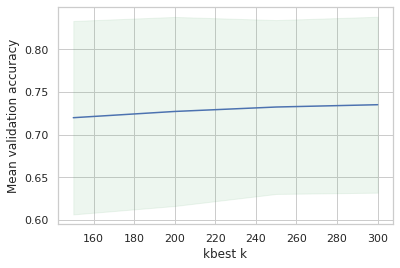

In [28]:
mean = search_results.groupby(by=['param_kbest__k'])['mean_test_score'].mean()
std = search_results.groupby(by=['param_kbest__k'])['std_test_score'].mean()

plt.plot(mean)
plt.fill_between(mean.index, mean-std, mean+std, alpha=0.1, color='g') # plot a band for std_test_score
plt.xlabel('kbest k')
plt.ylabel('Mean validation accuracy')
plt.show()

# looks like higher kbest k  gives the better VALIDATION accuracy, we may want to rerun GridSearch with higher k.

In [30]:
search_results.groupby(by=['param_pca__n_components'])['mean_test_score', 'std_test_score'].mean()

,mean_test_score,std_test_score
param_pca__n_components,,
5,0.707900,0.108689
20,0.727553,0.106445
30,0.732177,0.106898
40,0.732370,0.107298
50,0.734971,0.108919
60,0.736705,0.105197


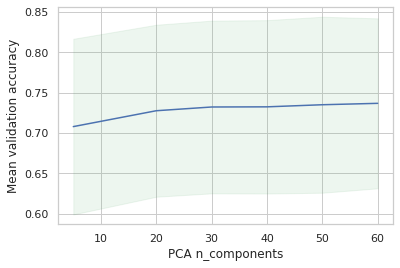

In [31]:
mean = search_results.groupby(by=['param_pca__n_components'])['mean_test_score'].mean()
std = search_results.groupby(by=['param_pca__n_components'])['std_test_score'].mean()

plt.plot(mean)
plt.fill_between(mean.index, mean-std, mean+std, alpha=0.1, color='g') # plot a band for std_test_score
plt.xlabel('PCA n_components')
plt.ylabel('Mean validation accuracy')

plt.show()

# looks like n_components=40 gives the best average VALIDATION accuracy. This, however, is dependent on the kbest.

In [32]:
search_results.groupby(by=['param_logistic__alpha'])['mean_test_score', 'std_test_score'].mean()

,mean_test_score,std_test_score
param_logistic__alpha,,
0.0001,0.783799,0.023427
0.0100,0.811095,0.017443
1.0000,0.815992,0.023646
100.0000,0.644509,0.221675
10000.0000,0.587669,0.250014


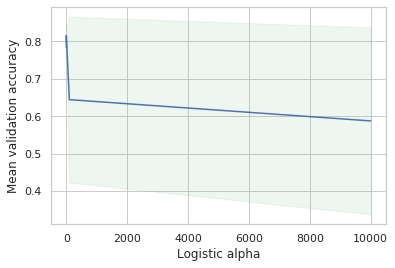

In [33]:
mean = search_results.groupby(by=['param_logistic__alpha'])['mean_test_score'].mean()
std = search_results.groupby(by=['param_logistic__alpha'])['std_test_score'].mean()

plt.plot(mean)
plt.fill_between(mean.index, mean-std, mean+std, alpha=0.1, color='g') # plot a band for std_test_score
plt.xlabel('Logistic alpha')
plt.ylabel('Mean validation accuracy')

plt.show()

# looks like logistic smaller alpha works better, we should keep it small if we try GridSearch again

### Evaluation Metrics

- Get best estimator (so far) from grid search
- Get predictions using TEST set
- Compute classification metrics

In [34]:
# search.predict automatically uses the best estimator
pred = search.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.74      0.41      0.53        41
           1       0.84      0.95      0.89       133

    accuracy                           0.83       174
   macro avg       0.79      0.68      0.71       174
weighted avg       0.82      0.83      0.81       174



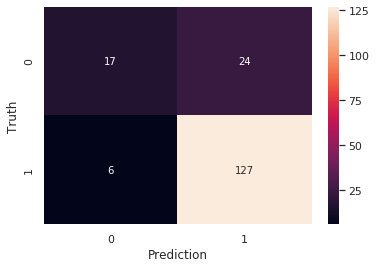

In [38]:
sns.heatmap(confusion_matrix(y_test, pred), annot=True, fmt='d')

# Workaround for: https://github.com/mwaskom/seaborn/issues/1773
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values

plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

In [0]:
# From the classification metrics we can see 18 mistakes in class 0, and 8 mistakes for class 1
# Let's examine the mistakes to see if we can get any insight

In [40]:
mistakes_mask = y_test != pred

mistakes = X_test.loc[mistakes_mask]
mistakes_y = y_test.loc[mistakes_mask]

mistakes.head()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,...,tqwt_skewnessValue_dec_33,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
111,1,0.75872,0.63853,0.62918,226,225,0.008538,0.000110,0.00275,0.000023,0.00062,0.00149,0.00185,0.03820,0.333,0.01908,0.02400,0.03535,0.05725,0.982489,0.018134,19.310,72.221228,76.836475,74.706679,645.759210,1180.726730,2622.798080,3920.759183,102.683863,73.392385,552.396791,499.997913,0.78979,8.1165,2.1463,0.76068,0.071207,0.113850,1924644.850,...,0.037724,-0.414770,-0.282120,-1.24950,3.6768,4.5424,4.7580,4.4177,4.3523,5.4964,4.3262,4.2088,4.5354,4.8689,3.3062,2.7569,2.6462,2.5183,2.4199,2.3747,2.4634,2.3268,2.1251,1.8831,2.3007,1.6038,1.5989,1.6243,1.8557,5.8695,4.0632,4.4710,3.3496,2.9341,3.5011,4.6154,3.3211,5.0572,3.4060,10.1983
50,0,0.84892,0.65789,0.36439,348,347,0.005558,0.000022,0.00044,0.000002,0.00009,0.00022,0.00028,0.02733,0.239,0.01276,0.01772,0.02440,0.03829,0.997496,0.002513,27.327,77.234505,78.877003,77.972524,693.389906,1212.167465,1858.424305,3073.677852,108.575741,178.806458,4481.268819,325.362399,1.00000,7.3526,0.0000,1.81920,0.494520,0.076636,2209866.657,...,-3.861700,-3.386600,-3.371000,-8.86400,251.4389,29.4210,91.5584,1450.6163,3195.4462,626.0990,23.0151,7.1730,5.9588,4.3679,6.5255,2.2723,2.0972,2.1961,2.8318,2.0724,1.8787,1.9864,1.7002,2.2633,1.5261,1.5681,1.6390,1.5150,1.5117,1.5132,8.1768,40.7534,44.4084,58.4233,71.7277,75.9943,67.4489,55.4218,46.7949,94.0764
11,1,0.84385,0.67496,0.46658,285,283,0.006773,0.002451,0.00129,0.000009,0.00026,0.00058,0.00077,0.11166,1.002,0.06565,0.07022,0.08624,0.19695,0.985050,0.015301,19.645,76.717847,78.856254,77.923276,588.767324,1179.520943,2565.191469,3196.519069,85.402947,208.065787,125.546448,436.439165,1.00000,5.5540,0.0000,1.02740,0.081440,0.122990,1451112.198,...,-0.162240,-0.428960,-0.338790,0.14077,8.2785,7.5075,7.5402,10.0738,12.9407,13.8252,4.7403,5.4656,5.0881,3.2291,2.8608,5.0347,2.9957,3.2356,2.9367,2.6686,2.5276,2.3365,1.8468,2.5334,1.8090,2.0684,2.0378,1.8992,1.8123,1.8861,138.0803,55.4951,14.7230,8.0903,4.5141,3.5522,4.5925,8.7307,5.9840,4.2463
14,0,0.86148,0.79945,0.37209,402,401,0.004809,0.000040,0.00096,0.000005,0.00023,0.00053,0.00068,0.05472,0.507,0.03190,0.03241,0.03717,0.09571,0.981793,0.018637,17.875,70.017409,73.955744,72.667600,413.735085,1220.773613,1768.000598,2877.676129,307.209400,358.062317,486.608104,88.418509,1.00000,17.4095,0.0000,0.97261,0.200630,0.155290,1066338.095,...,-0.040498,-0.200510,0.024807,-1.25400,11.4475,7.2278,6.0377,5.7452,5.3160,4.9563,4.1390,5.7596,5.4070,4.3707,5.7326,4.6033,3.0

In [41]:
correct_mask = y_test == pred

correct = X_test.loc[correct_mask]
correct_y = y_test.loc[correct_mask]

correct.head()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,...,tqwt_skewnessValue_dec_33,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
215,1,0.79028,0.76431,0.46302,192,191,0.010062,0.000109,0.00225,0.000023,0.00058,0.00120,0.00175,0.05609,0.495,0.03144,0.03104,0.04956,0.09432,0.984220,0.016191,19.972,74.759481,80.478024,78.307737,409.320179,1098.750404,2380.747328,3631.828369,48.793095,295.676601,367.293860,194.778722,0.79587,23.7653,2.6179,1.0677,0.31449,0.082233,1538385.116,...,-0.013449,-0.033042,-0.059755,-0.16487,6.7766,4.6005,4.1806,3.9639,4.2078,4.0703,3.6408,3.6269,3.1622,2.6118,3.0099,2.8320,2.9189,3.0808,3.4139,2.7909,2.0974,2.0104,2.6640,2.0371,1.7837,2.0390,1.7479,1.6841,1.6808,1.6196,23.6906,19.7914,9.9797,2.2322,2.0386,2.1475,2.9612,4.0307,3.5016,10.4449
58,1,0.80324,0.77800,0.33606,309,308,0.006233,0.000030,0.00100,0.000006,0.00019,0.00049,0.00058,0.02558,0.223,0.01312,0.01609,0.02301,0.03937,0.994490,0.005548,23.336,74.303113,76.409462,75.497479,550.804984,1311.642013,2438.298925,4207.319385,221.788975,124.527811,73.471496,236.261120,1.00000,38.4524,0.0000,1.3208,0.28204,0.082465,1696994.819,...,-3.746900,-3.363100,-3.121100,-8.85160,35.6402,11.4281,11.2140,11.9668,5.5295,4.7666,4.4083,4.3961,8.1873,4.0923,3.7150,4.7457,2.3705,2.1618,2.3815,2.6598,2.2704,2.1229,2.1449,2.3803,1.8047,2.4572,1.8745,1.5376,1.7177,2.8261,39.5048,43.3823,58.5239,59.6668,64.6540,71.8154,62.9809,52.8467,46.0655,94.7643
115,1,0.82783,0.65759,0.58702,319,318,0.006008,0.000069,0.00214,0.000013,0.00037,0.00090,0.00110,0.09284,0.823,0.04165,0.06270,0.09557,0.12496,0.974166,0.026894,16.675,75.993579,81.168805,78.579618,644.663348,1070.165564,2679.521299,3537.590088,126.554579,122.916495,178.582446,206.901808,1.00000,9.4963,0.0000,1.0694,0.26385,0.094242,1374816.256,...,-0.297920,-2.295700,-2.717900,-7.82690,9.3025,12.7824,17.7301,19.6494,18.9153,12.1626,4.6330,4.7153,5.1290,5.7675,5.7965,5.9767,2.8636,2.7153,2.8218,2.8559,2.2902,2.1634,2.6158,2.5638,2.1190,1.9614,2.5990,1.9789,1.9440,1.9122,1.9847,89.3323,63.8174,29.5278,6.8403,2.6973,3.9995,41.9838,41.2240,91.9788
197,0,0.84948,0.70178,0.25946,362,361,0.005320,0.000025,0.00060,0.000003,0.00009,0.00025,0.00028,0.02573,0.224,0.01407,0.01566,0.01985,0.04220,0.992958,0.007135,23.663,78.443047,81.448386,80.429859,701.443279,1231.600002,2692.096933,3799.628323,222.972301,191.455226,150.246519,354.779566,1.00000,30.7927,0.0000,1.0993,0.18445,0.133030,1320184.068,...,0.107380,-0.199670,-0.127000,0.19097,9.7655,6.4032,5.7025,4.9637,5.2504,5.9213,4.2853,3.9746,3.6105,3.6742,3.6141,2.2424,2.1805,2.

In [0]:
# Let's transform these data points using our pipeline

kbest = search.best_estimator_.named_steps['kbest']
scaler = search.best_estimator_.named_steps['scaler']
pca = search.best_estimator_.named_steps['pca']

Z_correct = pca.transform(scaler.transform(kbest.transform(correct)))
Z_mistakes = pca.transform(scaler.transform(kbest.transform(mistakes)))

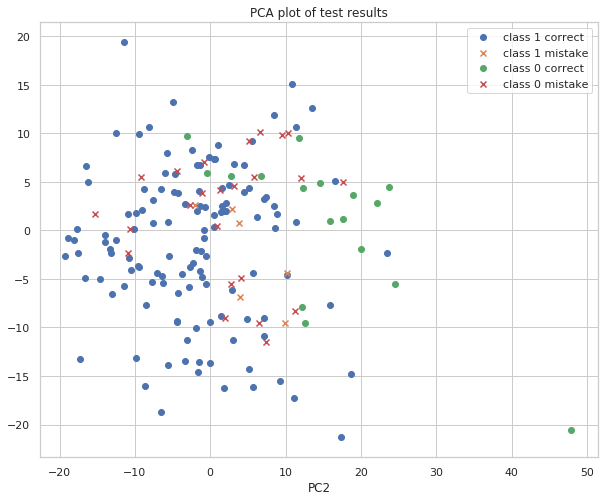

In [43]:
fig, ax = plt.subplots(figsize=(10, 8))

# Plot correct vs. mistakes for each class
for c in target.unique():
    # Use the top 2 components and mark the errors
    ax.scatter(Z_correct[correct_y == c, 0], Z_correct[correct_y == c, 1], 
               label=f'class {c} correct')
    ax.scatter(Z_mistakes[mistakes_y == c, 0], Z_mistakes[mistakes_y == c, 1], 
               label=f'class {c} mistake', marker='x')

ax.set_title(f'PCA plot of test results')
ax.set_xlabel('PC1')
ax.set_xlabel('PC2')

ax.legend()
plt.show()

# from the PCA plot, the boundary is somewhere down the center of the plot. You don't
# actually see a plane/line because we are only plotting 2 principal components

In [44]:
# Example of getting a prediction

# get some random samples from the holdout test set
test = X_test.sample(n=15, random_state=50)
test

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,...,tqwt_skewnessValue_dec_33,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
79,1,0.77279,0.62556,0.57142,260,259,0.007416,0.000112,0.00067,0.000005,0.00015,0.00034,0.00046,0.04871,0.438,0.02549,0.03052,0.04141,0.07648,0.990167,0.009957,20.751,72.317518,75.863649,74.089590,636.946865,1189.871805,2733.924966,3191.383485,70.891546,44.874669,143.048320,409.483706,0.79681,10.5895,2.6341,0.76339,0.063363,0.105670,1469826.372,...,-0.050716,-0.203910,-0.009968,-0.96137,5447.2016,96.1597,15.4974,11.7997,10.3543,7.5044,3.9595,4.8203,4.8062,3.9882,3.8633,5.9333,1.9931,2.0531,2.2975,2.7741,1.7763,1.9668,2.0369,2.6923,2.2716,1.8013,1.6482,2.0873,1.6899,1.6805,1.7860,2.2290,4.6081,3.0164,2.4102,2.4123,3.1930,4.8357,5.1990,7.4912
187,0,0.82242,0.63409,0.36482,284,283,0.004682,0.001183,0.00218,0.000010,0.00061,0.00056,0.00184,0.05268,0.464,0.02969,0.03207,0.04019,0.08907,0.989185,0.010999,20.829,76.124257,79.582325,77.593936,808.717066,1376.600760,2864.074110,3570.752091,170.249801,117.704796,494.389134,2601.562908,1.00000,3.9661,0.0000,1.49780,0.285140,0.102470,1784374.204,...,0.016800,-0.021297,-0.014852,0.35468,480.0139,18.4765,12.9703,13.2486,8.0595,6.6438,6.6459,4.5521,3.2627,3.4917,5.5551,2.8848,2.5520,2.7551,2.4472,2.3643,2.6360,2.2523,2.3370,1.8023,2.3619,1.7673,1.7282,1.7283,2.0686,50.8582,13.1581,8.8961,6.2693,5.0692,3.5687,2.7469,2.1213,2.2359,2.3334,2.9827
82,0,0.79141,0.82329,0.54703,377,376,0.005120,0.000046,0.00198,0.000010,0.00057,0.00126,0.00171,0.14769,1.307,0.07931,0.08702,0.12271,0.23792,0.943332,0.061297,12.867,33.190831,44.133492,39.984109,720.559287,1374.011227,2717.269568,3237.002172,245.888829,1132.433110,1013.452665,81.151542,0.77162,51.1474,16.4520,0.97210,0.229020,0.171280,1591215.580,...,-0.186970,-0.718840,-0.729080,-6.49110,13401.0151,6809.9894,6254.4743,6094.5272,5992.6642,5294.8760,440.6443,23.3377,10.2703,14.0442,22.2830,4.3422,3.2558,3.1605,3.3648,3.1218,2.9236,4.0867,6.2558,3.7463,2.6766,3.6410,2.1368,1.8997,1.8689,2.4421,4.5526,2.5600,2.5492,3.6574,3.1099,2.6128,3.1704,7.5835,9.1002,62.0868
177,1,0.79513,0.66976,0.38952,326,325,0.005928,0.000060,0.00077,0.000005,0.00012,0.00032,0.00037,0.02806,0.247,0.01636,0.01453,0.02051,0.04908,0.987332,0.012963,21.106,77.883302,79.840795,79.050504,625.226903,1004.297593,2832.196233,3372.730616,87.149459,82.785797,229.516218,118.285558,1.00000,8.2475,0.0000,0.98816,0.169360,0.099615,1492308.504,...,0.059243,0.179250,-0.003093,0.13337,5.9129,6.2788,6.5305,7.0415,7.1219,5.1282,3.8428,3.4751,3.6693,4.1075,4.3165,

In [45]:
# get the prediction of whether parkinson is diagnosed.
search.predict(test) 

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])